In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from datetime import datetime, timedelta


def df_to_X_y2(df,window_size=5):
    df_as_numpy=df.to_numpy()
    X=[]
    y=[]
    for i in range(len(df_as_numpy)-window_size):
        row=[a for a in df_as_numpy[i:i+window_size]]
        X.append(row)
        label=df_as_numpy[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

def plot_predictions3(model,X_sample,y):
    predictions=model.predict(X_sample).flatten()[1:].copy()
    df= pd.DataFrame(data={'Predictions':predictions,'Actuals':y[:-1]}).copy()
    plt.plot(df['Predictions']*oleo_std+oleo_mean,label='p')
    plt.plot(df['Actuals']*oleo_std+oleo_mean,label='a')
    plt.legend()
    plt.grid()
    return df, mse(y[:-1],predictions)

def fix_randoness():
    seed_value=42
    # Seed value
    # Apparently you may use different seed values at each stage

    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)
    # for later versions: 
    # tf.compat.v1.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    from keras import backend as K
    #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    #sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    #K.set_session(sess)
    # for later versions:
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [2]:
df=pd.read_csv('dados_unidos2.txt',sep='\t',decimal=',',encoding='UTF-8')
trocar_colunas={'Período': 'Data', 'Poço ANP':'Poco', 'Petróleo Equivalente (boe/d)':'boed',
           'Óleo (m3/d)':'oleo', 'Gás Natural (mil m3/d)':'gas', 'Água (m3/d)':'agua', 'Dias':'dias',
           'Potencial':'potencial'}
df=df.rename(columns=trocar_colunas)
df['BSW']=df['agua']/(df['agua']+df['oleo']+0.00000001)
#print(df.head)
#df=df[df.agua>0.1]
dfs_pocos=[]
for i in df.Poco.unique():
    dfs_pocos.append([i,df[df.Poco==i]])
dfs_pocos


[['7-RO-46HP-RJS',
             Data     Campo           Poco      boed     oleo     gas     agua  \
  0    2009-02-01  RONCADOR  7-RO-46HP-RJS  19768.52  2882.84  260.10     2.88   
  1    2009-03-01  RONCADOR  7-RO-46HP-RJS  19283.17  2820.46  245.32     2.82   
  2    2009-04-01  RONCADOR  7-RO-46HP-RJS  19129.89  2804.91  236.50     2.80   
  3    2009-05-01  RONCADOR  7-RO-46HP-RJS  18759.25  2799.78  182.71     2.80   
  4    2009-06-01  RONCADOR  7-RO-46HP-RJS  18617.98  2741.20  218.83     2.74   
  ..          ...       ...            ...       ...      ...     ...      ...   
  172  2023-06-01  RONCADOR  7-RO-46HP-RJS   8440.01  1279.62   62.24  1426.15   
  173  2023-07-01  RONCADOR  7-RO-46HP-RJS   8965.28  1355.36   70.01  1687.53   
  174  2023-08-01  RONCADOR  7-RO-46HP-RJS   7945.12  1191.41   71.77  1505.19   
  175  2023-09-01  RONCADOR  7-RO-46HP-RJS   8387.89  1251.29   82.28  1343.15   
  176  2023-10-01  RONCADOR  7-RO-46HP-RJS   8248.01  1230.95   80.38  1276.60 

In [3]:
df.Poco.unique()

array(['7-RO-46HP-RJS', '7-RO-50HPA-RJS', '7-RO-60HP-RJS',
       '7-RO-62HP-RJS', '7-RO-63HA-RJS', '7-RO-72HPB-RJS',
       '7-RO-74HP-RJS', '8-RO-58HP-RJS', '7-RO-135H-RJS'], dtype=object)

In [4]:
#eficiencias_escolha=[.2,.4,.6,.7,.8,.9]
#eficiencias_escolha=[.8,.85,.9]
eficiencias_escolha=[.7]
list_previsao=[]
list_erros=[]
list_prev_poco={}
#list_neurons=[[16,2],[32,4],[64,8],[128,16],[256,64],[512,128]]
list_neurons=[4,8,16,32,64,128,256]

for j in dfs_pocos[:]:
    for ef_escolhida in eficiencias_escolha:
        for neurons in list_neurons:
            df = j[1]
            print(df.Poco.unique())
            print(neurons)
            df['Data']=pd.to_datetime(df.Data, format='%Y-%m-%d')
            df.index=pd.to_datetime(df.Data, format='%Y-%m-%d')
            #data_inicial=0#df.Data.min()

            # Criar colunas de produção bruta e de óleo acumuladas em volume para normalizar o tempo
            df['mes'] = df.Data.apply(lambda x: x.days_in_month)
            df['tn']  = df['oleo']*df['mes']/1000000
            df['tn_2']= (df['oleo']+df['agua'])*df['mes']/1000000
            df['tn']  = df['tn'].cumsum()
            df['tn_2']= df['tn_2'].cumsum()
            # Calcular o BSW
            df['BSW']=df['agua']/(df['agua']+df['oleo']+0.0001)
            #separando o banco de dados para teste
            df_prev=df[-12:].copy()
            #separando o vector de eficiências do teste
            vector_ef=df_prev['ef']
            vector_dias_mes=df_prev['mes']
            #retirando valores de produção nulos
            df=df[df.oleo>0]
            # Achar o último bsw para estimar a bruta
            # separando os dados que serão utilizados para treino e validação
            df=df[:-12]
            bsw_median=df[-7:].BSW.median()
            #print('Tamanho antes do filtro:  ' +str(len(df)))
            # eficiência de corte
            #ef_escolhida=0.8
            df=df[df.ef>ef_escolhida]
            oleo=df[['oleo','tn_2']]
            tamanho_dados_entrada=len(oleo.columns)
            WINDOW_SIZE=3
            X, y = df_to_X_y2(oleo,window_size=WINDOW_SIZE)
            X.shape, y.shape
            n1=24
            n2=0
            n3=y.shape[0]
            delta_a=n3-n1
            delta_b=n3-n2
            X_train, y_train = X[:delta_a], y[:delta_a]
            X_val, y_val = X[delta_a:], y[delta_a:]

            oleo_mean = np.mean(X_train[:, :, 0])
            oleo_std = np.std(X_train[:, :, 0])
            ef_mean = np.mean(X_train[:, :, 1])
            ef_std = np.std(X_train[:, :, 1])

            def preprocess(Xd):
                Xd[:, :, 0] = (Xd[:, :, 0] - oleo_mean) / oleo_std 
                Xd[:, :, 1] = (Xd[:, :, 1] - ef_mean) / ef_std
                return Xd

            preprocess(X_train)
            preprocess(X_val)
            #preprocess(X_test)

            def preprocess_output(y):
                y[:] = (y[:] - oleo_mean) / oleo_std
                return y

            y_train=preprocess_output(y_train)
            y_val=preprocess_output(y_val)
            #y_test=preprocess_output(y_test)
            fix_randoness()
            model4=0
            cp4=0
            model4=Sequential()
            model4.add(InputLayer((WINDOW_SIZE,tamanho_dados_entrada)))
            model4.add(LSTM(neurons))
            #model4.add(Flatten())
            #model4.add(Dense(16,'relu'))
            model4.add(Dense(1,'linear'))
            #model4.summary()
            pasta='model'+j[0].split('-')[2]+'_'+str(ef_escolhida)+'/'
            #cp4=ModelCheckpoint(pasta,save_best_only=True)
            model4.compile(loss=MeanSquaredError(),optimizer='Adam', metrics=[RootMeanSquaredError()])
            model4.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=25,verbose=0)
            #model4.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=15,verbose=0,callbacks=[cp4])#,callbacks=[cp4]
            #model4= load_model(pasta)
            #plot_predictions3(model4,X,y)
            #plt.title(df.Poco.unique())
            #plt.show()
            #plt.clf()
            test_predictions=[]
            first_value=X_val[-1,1:,:].reshape(WINDOW_SIZE*2-2)
            ultimo_bp=df.tn_2.max()
            oleo_ultimo=(oleo.oleo[-1]-oleo_mean)/oleo_std
            tn_ultimo=(oleo.tn_2[-1]-ef_mean)/ef_std
            first_value=np.append(first_value,oleo_ultimo)
            first_value=np.append(first_value,tn_ultimo).reshape(1,WINDOW_SIZE,2)
            for i in range(12):
                current_pred=model4.predict(first_value)

                test_predictions.append(current_pred.reshape(1)[0])
                current_pred=current_pred.reshape(1)
                current_pred2=(current_pred*oleo_std+oleo_mean)*vector_ef[i]*vector_dias_mes[i]/(1-bsw_median)/1000000
                ultimo_bp=(ultimo_bp+current_pred2[0])
                ultimo_bp_trans=(ultimo_bp-ef_mean)/ef_std
                #print(ultimo_bp)
                #print(ultimo_bp_trans)
                first_value=np.append(first_value[:,1:,:].reshape(4),current_pred)
                first_value=np.append(first_value,ultimo_bp_trans).reshape(1,3,2)


            for i in range(len(test_predictions)):
                test_predictions[i]=(test_predictions[i]*oleo_std+oleo_mean)*vector_ef[i]
            test_predictions
            #plt.plot(np.array(test_predictions),label='p')
            #plt.plot((df_prev['oleo']/(df_prev['ef']+0.001)).values,label='a')
            #plt.plot((df_prev['oleo']/(1)).values,label='a_ef')

            #plt.ylim(0)
            #plt.grid()
            #plt.legend()
            list_previsao.append([j[0],ef_escolhida,test_predictions])
            list_erros.append([j[0], MAPE((df_prev['oleo']).values,np.array(test_predictions)),ef_escolhida,mse((df_prev['oleo']).values,np.array(test_predictions), squared=True),neurons])
    list_previsao.append([j[0],'prev',(df_prev['oleo']).values])
print('pronto!')




['7-RO-46HP-RJS']
4




1/1 [==============================] - 0s 17ms/step
['7-RO-46HP-RJS']
8
1/1 [==============================] - 0s 16ms/step
['7-RO-46HP-RJS']
16
1/1 [==============================] - 0s 16ms/step
['7-RO-46HP-RJS']
32
1/1 [==============================] - 0s 17ms/step
['7-RO-46HP-RJS']
64
1/1 [==============================] - 0s 16ms/step
['7-RO-46HP-RJS']
128
1/1 [==============================] - 0s 17ms/step
['7-RO-46HP-RJS']
256
1/1 [==============================] - 0s 16ms/step
['7-RO-50HPA-RJS']
4
1/1 [==============================] - 0s 16ms/step
['7-RO-50HPA-RJS']
8
1/1 [==============================] - 0s 17ms/step
['7-RO-50HPA-RJS']
16
1/1 [==============================] - 0s 16ms/step
['7-RO-50HPA-RJS']
32
1/1 [==============================] - 0s 16ms/step
['7-RO-50HPA-RJS']
64
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
['7-RO-50HPA-RJS']
128
1/1 [==============================] - 0s 17ms/step
['7-RO-50HPA-RJS']
256
1/1 [==============================] - 0s 15ms/step
['7-RO-60HP-RJS']
4
1/1 [==============================] - 0s 16ms/step
['7-RO-60HP-RJS']
8
1/1 [==============================] - 0s 17ms/step
['7-RO-60HP-RJS']
16
1/1 [==============================] - 0s 15ms/step
['7-RO-60HP-RJS']
32
1/1 [==============================] - 0s 15ms/step
['7-RO-60HP-RJS']
64
1/1 [==============================] - 0s 16ms/step
['7-RO-60HP-RJS']
128
1/1 [==============================] - 0s 15ms/step
['7-RO-60HP-RJS']
256
1/1 [==============================] - 0s 16ms/step
['7-RO-62HP-RJS']
4
1/1 [==============================] - 0s 14ms/step
['7-RO-62HP-RJS']
8
1/1 [==============================] - 0s 16ms/step
['7-RO-62HP-RJS']
16
1/1 [==============================] - 0s 16ms/step
['7-RO-62HP-RJS']
32
1/1 [==============================] - 0s 290ms/s

1/1 [==============================] - 0s 15ms/step
['7-RO-62HP-RJS']
64
1/1 [==============================] - 0s 17ms/step
['7-RO-62HP-RJS']
128
1/1 [==============================] - 0s 17ms/step
['7-RO-62HP-RJS']
256
1/1 [==============================] - 0s 15ms/step
['7-RO-63HA-RJS']
4
1/1 [==============================] - 0s 15ms/step
['7-RO-63HA-RJS']
8
1/1 [==============================] - 0s 16ms/step
['7-RO-63HA-RJS']
16
1/1 [==============================] - 0s 15ms/step
['7-RO-63HA-RJS']
32
1/1 [==============================] - 0s 16ms/step
['7-RO-63HA-RJS']
64
1/1 [==============================] - 0s 16ms/step
['7-RO-63HA-RJS']
128
1/1 [==============================] - 0s 15ms/step
['7-RO-63HA-RJS']
256
1/1 [==============================] - 0s 15ms/step
['7-RO-72HPB-RJS']
4
1/1 [==============================] - 0s 17ms/step
['7-RO-72HPB-RJS']
8
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
['7-RO-72HPB-RJS']
16
1/1 [==============================] - 0s 18ms/step
['7-RO-72HPB-RJS']
32
1/1 [==============================] - 0s 17ms/step
['7-RO-72HPB-RJS']
64
1/1 [==============================] - 0s 17ms/step
['7-RO-72HPB-RJS']
128
1/1 [==============================] - 0s 15ms/step
['7-RO-72HPB-RJS']
256
1/1 [==============================] - 0s 16ms/step
['7-RO-74HP-RJS']
4
1/1 [==============================] - 0s 16ms/step
['7-RO-74HP-RJS']
8
1/1 [==============================] - 0s 16ms/step
['7-RO-74HP-RJS']
16
1/1 [==============================] - 0s 18ms/step
['7-RO-74HP-RJS']
32
1/1 [==============================] - 0s 17ms/step
['7-RO-74HP-RJS']
64
1/1 [==============================] - 0s 17ms/step
['7-RO-74HP-RJS']
128
1/1 [==============================] - 0s 15ms/step
['7-RO-74HP-RJS']
256
1/1 [==============================] - 0s 15ms/step
['8-RO-58HP-RJS']
4
1/1 [==============================] - 0s 16m

1/1 [==============================] - 0s 16ms/step
['8-RO-58HP-RJS']
8
1/1 [==============================] - 0s 16ms/step
['8-RO-58HP-RJS']
16
1/1 [==============================] - 0s 16ms/step
['8-RO-58HP-RJS']
32
1/1 [==============================] - 0s 19ms/step
['8-RO-58HP-RJS']
64
1/1 [==============================] - 0s 15ms/step
['8-RO-58HP-RJS']
128
1/1 [==============================] - 0s 15ms/step
['8-RO-58HP-RJS']
256
1/1 [==============================] - 0s 17ms/step
['7-RO-135H-RJS']
4
1/1 [==============================] - 0s 16ms/step
['7-RO-135H-RJS']
8
1/1 [==============================] - 0s 15ms/step
['7-RO-135H-RJS']
16
1/1 [==============================] - 0s 16ms/step
['7-RO-135H-RJS']
32
1/1 [==============================] - 0s 17ms/step
['7-RO-135H-RJS']
64
1/1 [==============================] - 0s 15ms/step
['7-RO-135H-RJS']
128
1/1 [==============================] - 0s 15ms/step
['7-RO-135H-RJS']
256
1/1 [==============================] - 0s 284ms/st

1/1 [==============================] - 0s 16ms/step
pronto!


In [5]:
analise_erro=pd.DataFrame(list_erros,columns=['poco','mape','ef','erro','neurons'])
pd.pivot_table(analise_erro,index='neurons',values='mape',aggfunc='mean')

,mape
neurons,
4,2.008771
8,1.112323
16,0.934012
32,0.239354
64,0.148426
128,0.301619
256,0.413401


In [17]:
a=pd.DataFrame(list_previsao)
a

,0,1,2
0,7-RO-46HP-RJS,0.7,"[158.71039501999147, 1207.5067987937962, 1765...."
1,7-RO-46HP-RJS,0.7,"[123.942775455523, 948.8611258059516, 1404.129..."
2,7-RO-46HP-RJS,0.7,"[111.30701128343902, 855.315320321995, 1257.27..."
3,7-RO-46HP-RJS,0.7,"[95.30122852264518, 734.7487416321923, 1071.89..."
4,7-RO-46HP-RJS,0.7,"[94.1869730287231, 730.5483115009549, 1067.698..."
...,...,...,...
67,7-RO-135H-RJS,0.7,"[422.76517688506925, 653.0603155894737, 563.50..."
68,7-RO-135H-RJS,0.7,"[275.55778442549854, 431.10340008916114, 373.1..."
69,7-RO-135H-RJS,0.7,"[215.1694025921164, 330.95611705753186, 279.95..."
70,7-RO-135H-RJS,0.7,"[274.09662735531026, 429.03418879858157, 371.5..."


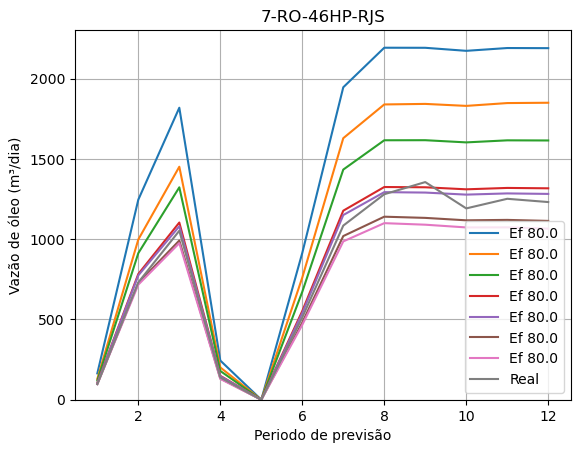

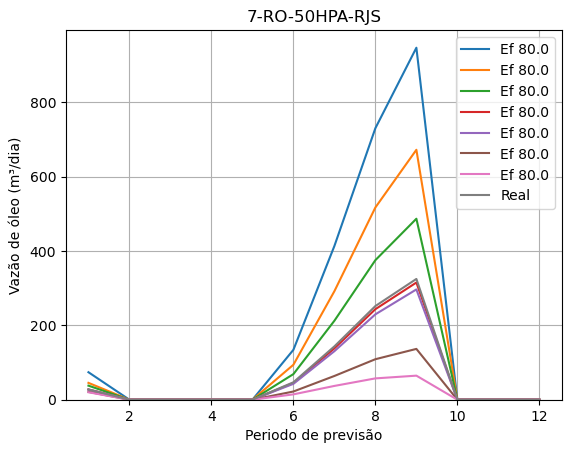

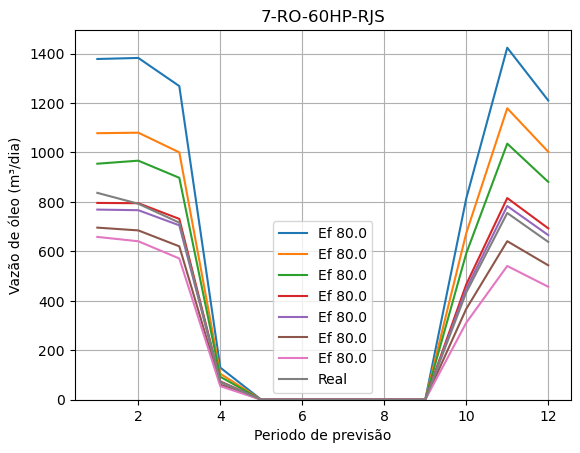

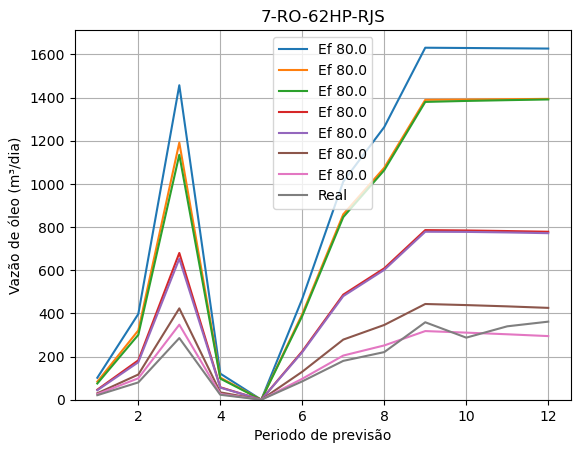

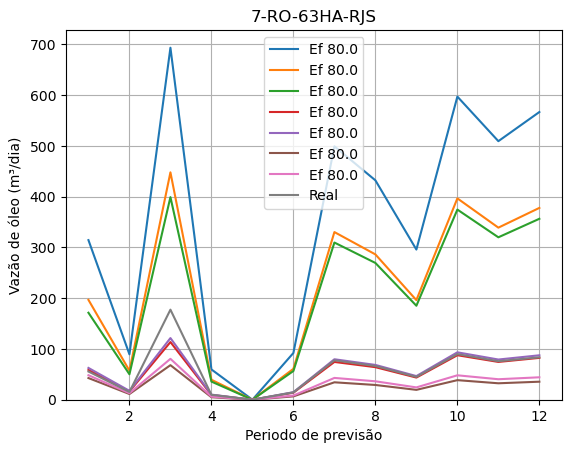

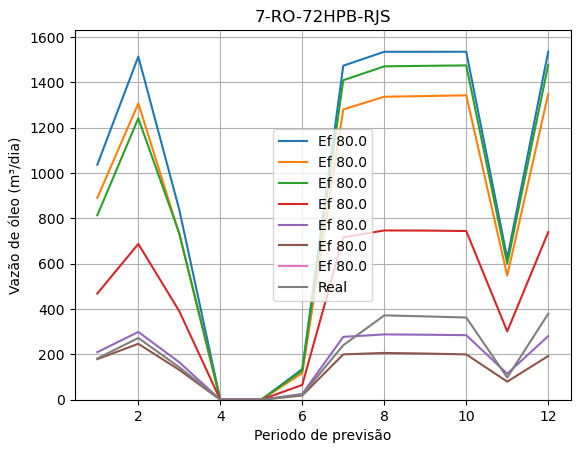

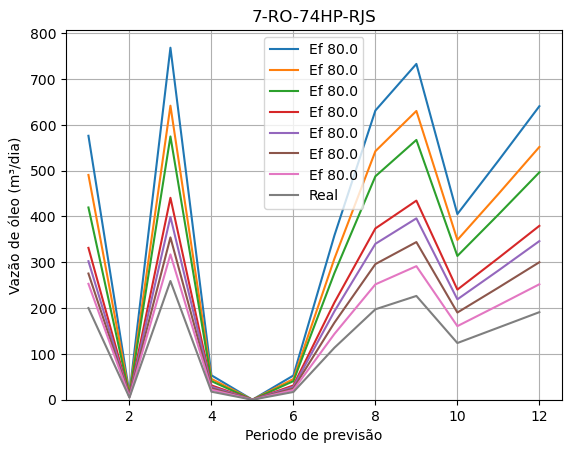

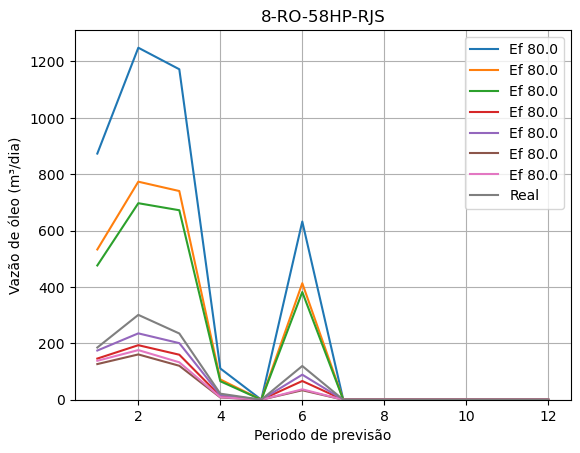

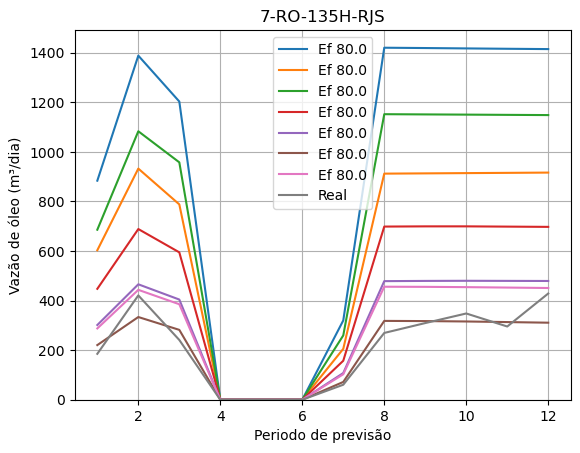

<Figure size 640x480 with 0 Axes>

In [12]:
#df_prev
a=pd.DataFrame(list_previsao)
for i in a[0].unique():
    b = a[a[0]==i]
    #print(b)
    for index, j in b.iterrows():
        if j[1] == 'prev':
            plt.plot(list(range(1,len(j[2])+1)),j[2],label='Real')
        else:
            plt.plot(list(range(1,len(j[2])+1)),j[2],label='Ef '+str(j[1]*100))
    plt.ylabel('Vazão de óleo (m³/dia)')
    plt.xlabel('Periodo de previsão')
    plt.ylim(0)
    plt.title(i)
    plt.grid()
    plt.legend()
    plt.show()
    plt.clf()

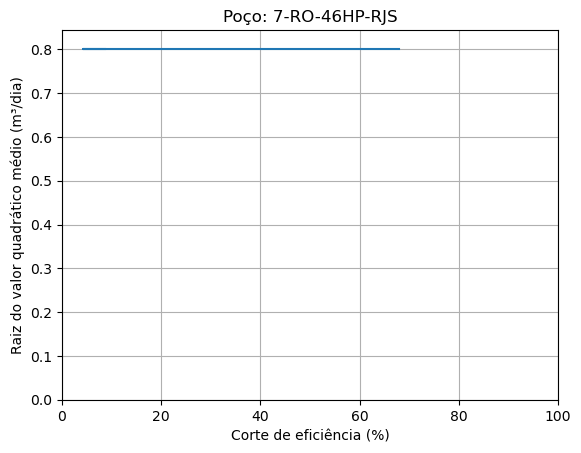

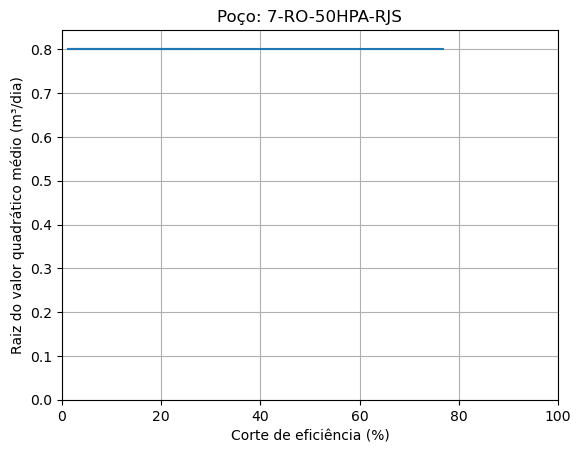

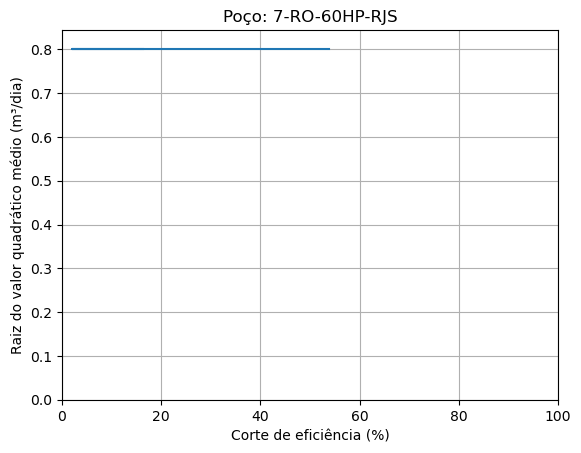

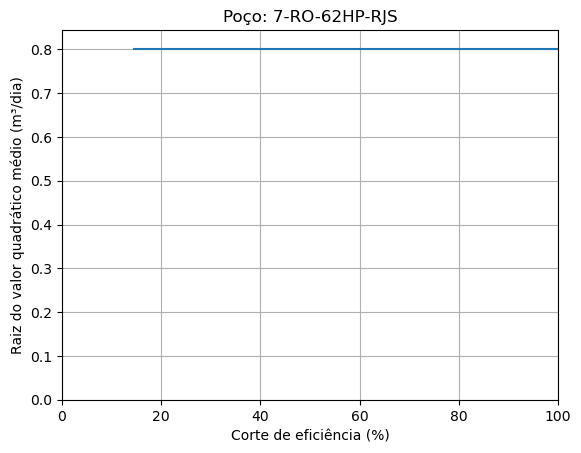

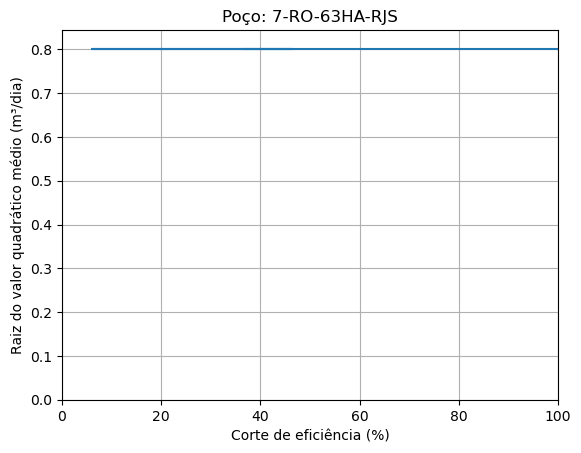

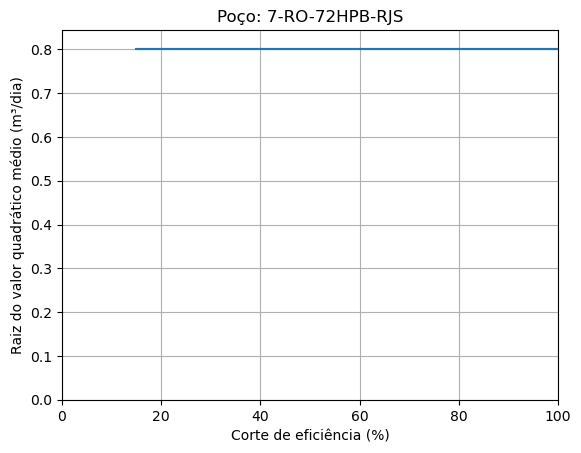

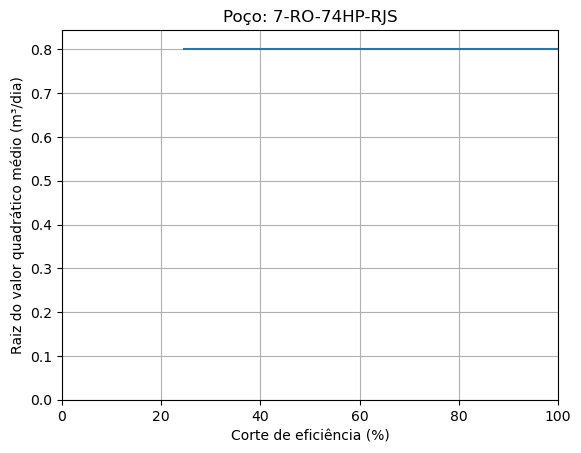

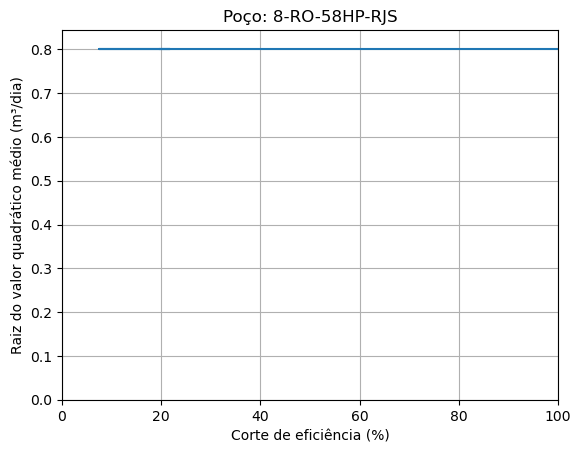

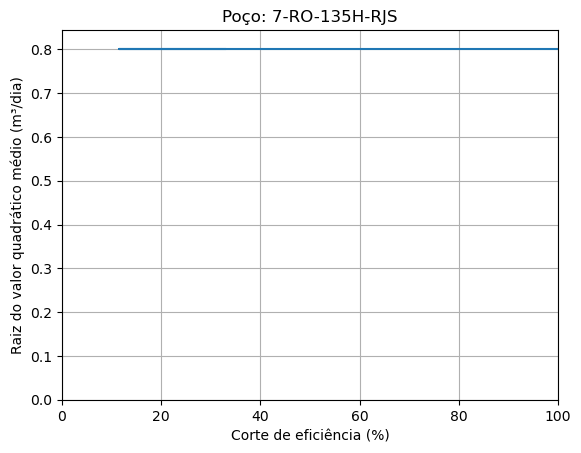

<Figure size 640x480 with 0 Axes>

In [13]:
a=pd.DataFrame(list_erros)
for i in a[0].unique():
    filtro=a[0]==i
    #plt.plot(a[filtro][1],a[filtro][2]/a[filtro][2].max())
    plt.plot(a[filtro][1]*100,a[filtro][2])
    plt.title('Poço: '+i)
    plt.xlabel('Corte de eficiência (%)')
    plt.ylabel('Raiz do valor quadrático médio (m³/dia)')
    plt.xlim(0,100)
    plt.ylim(0)
    plt.grid()
    plt.show()
    plt.clf()
    


In [14]:
a=pd.DataFrame(list_erros)
a.columns = ['poco','ef','error']
#a.to_csv('lista_erros.txt',sep='\t',decimal=',',index=None)
b=pd.pivot_table(a,index='poco',values='error',aggfunc='min').reset_index()
b=b.merge(a,how='left', on=['poco','error']).drop_duplicates(subset='error')
a=pd.DataFrame(list_previsao)
a.columns=['poco','ef','previsao']

b=b.merge(a,on=['poco','ef'],how='left')
b['previsao']=b['previsao'].apply(lambda x: np.array(x))
b.previsao.sum()
c=a[a.ef=='prev'].copy()
c['previsao']=c['previsao'].apply(lambda x: np.array(x))
c.previsao.sum()

ValueError: Length mismatch: Expected axis has 5 elements, new values have 3 elements

In [ ]:
plt.plot(c.previsao.sum(),label='Real')
plt.plot(b.previsao.sum(),label='Estimado')
plt.ylabel('Vazão de óleo (m³/d)')
plt.xlabel('Período estimado')
plt.title('Estimativa de vazão da plataforma P-54')
plt.grid()
plt.ylim(0)
plt.legend()
plt.show()
plt.clf()
mse(c.previsao.sum(),b.previsao.sum())

In [ ]:
c.previsao.sum()-b.previsao.sum()

,Data,Campo,Poco,boed,oleo,gas,agua,dias,potencial,ef,BSW,mes,tn,tn_2
Data,,,,,,,,,,,,,,
2022-07-01,2022-07-01,RONCADOR,7-RO-135H-RJS,396.00,56.90,6.06,165.92,8.986301,301.786821,0.188544,0.744637,31,2.603560,6.669414
2022-08-01,2022-08-01,RONCADOR,7-RO-135H-RJS,191.50,28.08,2.36,91.58,9.071233,298.129581,0.094187,0.765334,31,2.604430,6.673123
2022-09-01,2022-09-01,RONCADOR,7-RO-135H-RJS,839.76,121.62,11.89,379.93,9.156164,294.540583,0.412914,0.757512,30,2.608079,6.688170
2022-11-01,2022-11-01,RONCADOR,7-RO-135H-RJS,1239.01,185.19,11.80,668.45,9.323288,287.671052,0.643756,0.783058,30,2.613635,6.713779
2022-12-01,2022-12-01,RONCADOR,7-RO-135H-RJS,2874.83,420.86,36.20,1694.77,9.405479,284.383282,1.000000,0.801071,31,2.626681,6.779363
2023-01-01,2023-01-01,RONCADOR,7-RO-135H-RJS,1628.60,241.06,17.86,1174.12,9.490411,281.046709,0.857722,0.829661,31,2.634154,6.823234
2023-05-01,2023-05-01,RONCADOR,7-RO-135H-RJS,404.22,60.51,3.75,278.89,9.819178,268.686278,0.225207,0.821715,31,2.636030,6.833755
2023-06-01,2023-06-01,RONCADOR,7-RO-135H-RJS,1790.96,269.44,15.30,1159.11,9.904110,265.629939,1.000000,0.811389,30,2.644113,6.876612
2023-07-01,2023-07-01,RONCADOR,7-RO-135H-RJS,2064.99,309.27,19.04,1567.23,9.986301,262.723193,1.000000,0.835188,31,2.653700,6.934783


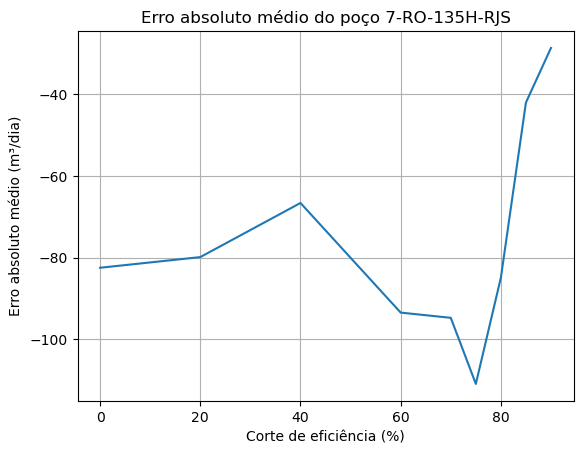

<Figure size 640x480 with 0 Axes>

In [11]:
lista_erro_absoluto=[]
a=pd.DataFrame(list_previsao)
a.columns=['poco','ef','previsao']
a=a[a.poco=='7-RO-135H-RJS']
ef_loop=a.ef.unique()[:-1]
ef_loop
for i in ef_loop:
    erro=a[a.ef==i].previsao.values-a[a.ef=='prev'].previsao.values
    lista_erro_absoluto.append(erro.sum().sum()/12)
plt.plot(ef_loop*100,lista_erro_absoluto)
plt.grid()
plt.ylabel('Erro absoluto médio (m³/dia)')
plt.xlabel('Corte de eficiência (%)')
plt.title('Erro absoluto médio do poço 7-RO-135H-RJS')
plt.show()
plt.clf()

In [12]:
lista_erro_absoluto=[]
